# LLM Fine-Tuning for Disease Suggestion Based on Symptoms

## Assignment Overview
This notebook implements fine-tuning of an open-source Large Language Model (LLM) to suggest medical conditions based on symptoms. The project includes:
- Dataset preparation from Kaggle
- LLM fine-tuning using QLoRA/LoRA
- Model evaluation with confusion matrix
- Demo queries showing model capabilities
- Safety disclaimers for educational purposes

**IMPORTANT**: This project is strictly educational and should NOT be used for real medical advice. Always consult a qualified healthcare professional for medical concerns.

## Section 1: Import Required Libraries and Setup

In [ ]:
import torch
import numpy as np
import pandas as pd
import json
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# Transformers and training libraries
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig
)
from datasets import Dataset, load_dataset
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"}')

Using device: cuda
Device: Tesla T4


## Section 2: Dataset Preparation

### Step 1: Download and Load Kaggle Dataset
Download the disease and symptoms dataset from Kaggle and prepare it for fine-tuning.

**Dataset Source**: https://www.kaggle.com/datasets/choongqianzheng/disease-and-symptoms-dataset

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d choongqianzheng/disease-and-symptoms-dataset

# Unzip the dataset and load the CSV
!unzip -o disease-and-symptoms-dataset.zip
df = pd.read_csv('DiseaseAndSymptoms.csv')

print('Actual Kaggle Dataset Loaded:')
print(df.head())
print(f'\nDataset shape: {df.shape}')

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/choongqianzheng/disease-and-symptoms-dataset
License(s): other
disease-and-symptoms-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  disease-and-symptoms-dataset.zip
  inflating: Disease precaution.csv  
  inflating: DiseaseAndSymptoms.csv  
Actual Kaggle Dataset Loaded:
            Disease   Symptom_1              Symptom_2              Symptom_3  \
0  Fungal infection     itching              skin_rash   nodal_skin_eruptions   
1  Fungal infection   skin_rash   nodal_skin_eruptions    dischromic _patches   
2  Fungal infection     itching   nodal_skin_eruptions    dischromic _patches   
3  Fungal infection     itching              skin_rash    dischromic _patches   
4  Fungal infection     itching              skin_rash   nodal_skin_eruptions   

              Symptom_4 Symptom_5 Symptom_6 Symptom_7 Symptom_8 Symptom_9  \
0   dischromic _patches      

### Step 2: Create Training and Test JSONL Files

In [ ]:
def create_training_data(df):
    """
    Convert disease-symptoms data into instruction-following format
    """
    training_data = []

    for idx, row in df.iterrows():
        disease = row['Disease']
        symptoms = [row['Symptom_1'], row['Symptom_2'], row['Symptom_3'], row['Symptom_4']]
        symptoms_text = ', '.join([s for s in symptoms if pd.notna(s)]) # Filter out NaN values

        # Create training entry in the required format
        entry = {
            'instruction': 'Identify the disease pattern based on symptoms.',
            'input': symptoms_text,
            'output': f'Disease: {disease}\nExplanation: These symptoms frequently match {disease} patterns in the dataset.\nNote: This is not medical advice.'
        }
        training_data.append(entry)

    return training_data

# Create training data
training_data = create_training_data(df)

# Split into train, validation, and test (70-15-15 split)
num_total = len(training_data)
num_train = int(num_total * 0.7)
num_val = int(num_total * 0.15)
num_test = num_total - num_train - num_val

train_data = training_data[:num_train]
validation_data = training_data[num_train : num_train + num_val]
final_test_data = training_data[num_train + num_val : ]

print(f'Total samples: {num_total}')
print(f'Training samples: {len(train_data)}')
print(f'Validation samples: {len(validation_data)}')
print(f'Test samples: {len(final_test_data)}')

# Show example
print('\nExample training entry:')
print(json.dumps(training_data[0], indent=2))

# Save as JSONL files
def save_jsonl(data, filename):
    """Save data as JSONL file"""
    with open(filename, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')
    print(f'Saved {len(data)} entries to {filename}')

save_jsonl(train_data, 'train.jsonl')
save_jsonl(validation_data, 'validation.jsonl')
save_jsonl(final_test_data, 'test.jsonl')

Total samples: 4920
Training samples: 3444
Validation samples: 738
Test samples: 738

Example training entry:
{
  "instruction": "Identify the disease pattern based on symptoms.",
  "input": "itching,  skin_rash,  nodal_skin_eruptions,  dischromic _patches",
  "output": "Disease: Fungal infection\nExplanation: These symptoms frequently match Fungal infection patterns in the dataset.\nNote: This is not medical advice."
}
Saved 3444 entries to train.jsonl
Saved 738 entries to validation.jsonl
Saved 738 entries to test.jsonl


## Section 3: Load Pre-trained Model and Tokenizer

We'll use a lightweight open-source LLM suitable for fine-tuning. Options include:
- **LLaMA 3.2 (1B/3B)**: Meta's efficient model
- **Mistral 7B**: Fast and capable
- **Gemma 2B**: Google's compact model
- **TinyLLaMA**: Smallest option for resource-constrained environments

In [ ]:
!pip install -U bitsandbytes

In [ ]:
# Model selection - choose one
MODEL_ID = 'TinyLlama/TinyLlama-1.1B-Chat-v1.0'  # Lightweight option
# MODEL_ID = 'mistralai/Mistral-7B'
# MODEL_ID = 'google/gemma-2b'
# MODEL_ID = 'meta-llama/Llama-2-7b-hf'

print(f'Loading model: {MODEL_ID}')

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Quantization config for memory efficiency (4-bit)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True,
    dtype=torch.float16 # Changed from torch_dtype to dtype to address deprecation warning
)

print(f'Model loaded successfully')
print(f'Model parameters: {model.num_parameters():,}')

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded successfully
Model parameters: 1,100,048,384


## Section 4: Prepare and Preprocess Training Data

In [ ]:
def format_prompt(instruction, input_text, output_text=''):
    """Format data into instruction-following prompt"""
    prompt = f'''### Instruction:
{instruction}

### Input:
{input_text}

### Output:
{output_text}'''
    return prompt

def preprocess_function(examples):
    """Tokenize and format the training data"""
    texts = []
    for instruction, input_text, output in zip(examples['instruction'],
                                               examples['input'],
                                               examples['output']):
        text = format_prompt(instruction, input_text, output)
        texts.append(text)

    # Tokenize
    tokenized = tokenizer(
        texts,
        truncation=True,
        max_length=512,
        padding='max_length',
        return_tensors='pt'
    )

    # For causal LM, labels are the same as input_ids
    tokenized['labels'] = tokenized['input_ids'].clone()

    return tokenized

# Load training data
train_dataset = Dataset.from_dict({
    'instruction': [d['instruction'] for d in train_data],
    'input': [d['input'] for d in train_data],
    'output': [d['output'] for d in train_data]
})

validation_dataset = Dataset.from_dict({
    'instruction': [d['instruction'] for d in validation_data],
    'input': [d['input'] for d in validation_data],
    'output': [d['output'] for d in validation_data]
})

final_test_dataset = Dataset.from_dict({
    'instruction': [d['instruction'] for d in final_test_data],
    'input': [d['input'] for d in final_test_data],
    'output': [d['output'] for d in final_test_data]
})

# Preprocess datasets
train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['instruction', 'input', 'output'])
validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=['instruction', 'input', 'output'])
final_test_dataset = final_test_dataset.map(preprocess_function, batched=True, remove_columns=['instruction', 'input', 'output'])

print(f'Training dataset: {train_dataset}')
print(f'Validation dataset: {validation_dataset}')
print(f'Final Test dataset: {final_test_dataset}')

Map:   0%|          | 0/3444 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Map:   0%|          | 0/738 [00:00<?, ? examples/s]

Training dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 3444
})
Validation dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 738
})
Final Test dataset: Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 738
})


## Section 5: Configure LoRA/QLoRA Parameters

In [ ]:
# Configure LoRA (Low-Rank Adaptation)
lora_config = LoraConfig(
    r=8,  # Rank dimension
    lora_alpha=16,  # Alpha scaling
    target_modules=['q_proj', 'v_proj', 'k_proj', 'out_proj'],  # Target attention modules
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.CAUSAL_LM
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Check trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f'Trainable params: {trainable_params:,} || All params: {all_params:,} || Trainable%: {100 * trainable_params / all_params}')

print_trainable_parameters(model)

Trainable params: 1,531,904 || All params: 617,138,176 || Trainable%: 0.2482270680334642


## Section 6: Configure Training Parameters and Initialize Trainer

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    warmup_steps=10,
    weight_decay=0.01,
    logging_steps=5,
    eval_strategy='epoch',  # Calculate validation loss only after each epoch
    save_strategy='epoch',
    load_best_model_at_end=True, # Ensure the best model is loaded into trainer.model after training
    push_to_hub=False,
    report_to='none',
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset, # Use the new validation dataset
    tokenizer=tokenizer,
)

print('Trainer initialized successfully')
print(f'Training arguments:\n{training_args}')

Trainer initialized successfully
Training arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=True,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=

## Section 7: Fine-tune the Model

Start the training loop. This will fine-tune the model for at least 2 epochs.

In [ ]:
# Start training
print('Starting training...')
train_result = trainer.train()

# Print training summary
print(f'\nTraining completed!')
print(f'Training loss: {train_result.training_loss}')

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Starting training...


Epoch,Training Loss,Validation Loss
1,0.016100,0.011032
2,0.013700,0.008925



Training completed!
Training loss: 0.2855170307607496


## Section 8: Save the Fine-tuned Model

In [ ]:
# Save the fine-tuned adapter
model.save_pretrained('./finetuned_disease_model')
tokenizer.save_pretrained('./finetuned_disease_model')

print('Model and tokenizer saved successfully!')
print('Files saved in: ./finetuned_disease_model/')

Model and tokenizer saved successfully!
Files saved in: ./finetuned_disease_model/


## Section 9: Run Predictions and Generate Confusion Matrix

Now we'll make predictions on the test set and create a confusion matrix.

In [ ]:

def extract_disease_from_output(output_text):
    """
    Extract disease name from model output
    Expected format: "Disease: <disease_name>"
    """
    try:
        # Look for 'Disease:' in the output
        if 'Disease:' in output_text:
            disease_part = output_text.split('Disease:')[1].split('\n')[0].strip()
            return disease_part
        return 'Unknown'
    except:
        return 'Unknown'

def generate_predictions(model, tokenizer, test_data, device='cuda'):
    """
    Generate predictions on test data
    """
    actual_diseases = []
    predicted_diseases = []

    model.eval()
    with torch.no_grad():
        for item in test_data:
            # Format input
            input_text = format_prompt(item['instruction'], item['input'], '')

            # Tokenize
            inputs = tokenizer(input_text, return_tensors='pt', truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Generate
            outputs = model.generate(
                **inputs,
                max_new_tokens=100,
                temperature=0.7,
                top_p=0.9,
                do_sample=True
            )

            # Decode
            response = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Extract disease
            predicted_disease = extract_disease_from_output(response)
            actual_disease = extract_disease_from_output(item['output'])

            actual_diseases.append(actual_disease)
            predicted_diseases.append(predicted_disease)

    return actual_diseases, predicted_diseases

# Generate predictions using the final_test_data
print('Generating predictions on final test set...')
actual_diseases, predicted_diseases = generate_predictions(model, tokenizer, final_test_data, device)

print(f'\nActual diseases: {actual_diseases}')
print(f'Predicted diseases: {predicted_diseases}')

Generating predictions on final test set...

Actual diseases: ['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis', 'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes', 'Gastroenteritis', 'Bronchial Asthma', 'Hypertension', 'Migraine', 'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice', 'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A', 'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia', 'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins', 'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia', 'Osteoarthristis', 'Arthritis', '(vertigo) Paroymsal  Positional Vertigo', 'Acne', 'Urinary tract infection', 'Psoriasis', 'Impetigo', 'Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis', 'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes', 'Gastroenteritis', 'Bronchial Asthma', 'Hypertension', 'Migraine', 'Cervical spondylosis', 'Paralysis (brain hemorr

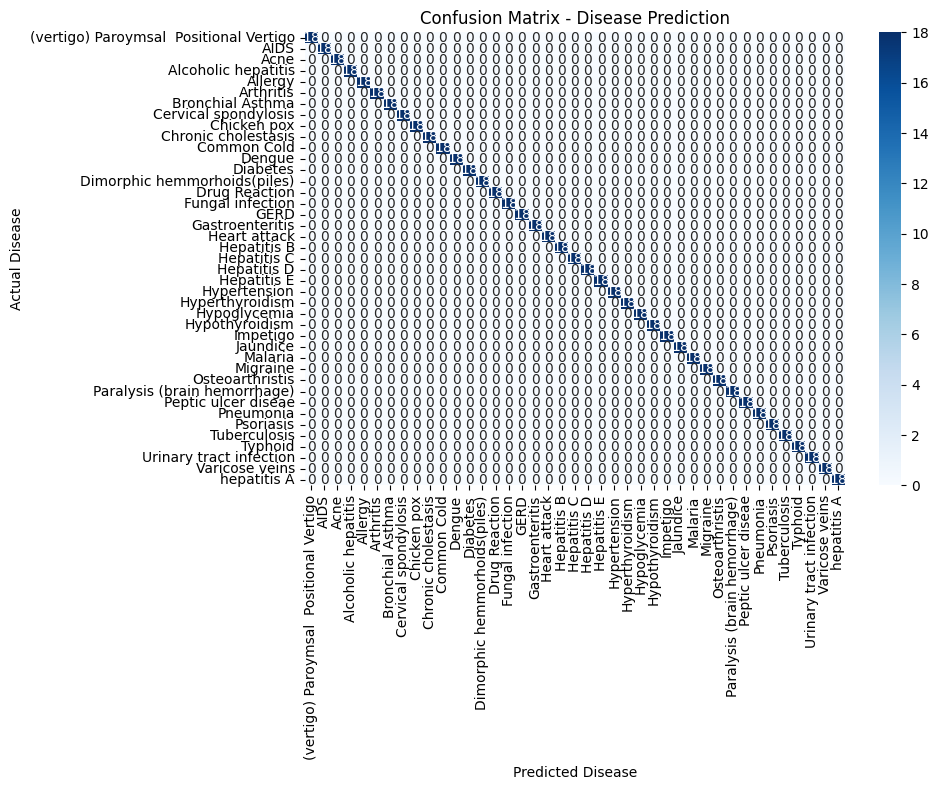


Confusion Matrix saved as 'confusion_matrix.png'

Confusion Matrix:
[[18  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 18  0]
 [ 0  0  0 ...  0  0 18]]

Accuracy: 100.00%

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        18
                                   Acne       1.00      1.00      1.00        18
                    Alcoholic hepatitis       1.00      1.00      1.00        18
                                Allergy       1.00      1.00      1.00        18
                              Arthritis       1.00      1.00      1.00        18
                       Bronchial Asthma       1.00      1.00      1.00        18
                   Cervical spondylosis       1.00      1.00      1.00        18
  

In [ ]:
# Generate and visualize confusion matrix
cm = confusion_matrix(actual_diseases, predicted_diseases)

# Get unique labels
labels = sorted(list(set(actual_diseases + predicted_diseases)))

# Create a more detailed confusion matrix
cm = confusion_matrix(actual_diseases, predicted_diseases, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Disease Prediction')
plt.ylabel('Actual Disease')
plt.xlabel('Predicted Disease')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nConfusion Matrix saved as \'confusion_matrix.png\'')
print(f'\nConfusion Matrix:\n{cm}')

# Calculate metrics
accuracy = accuracy_score(actual_diseases, predicted_diseases)
print(f'\nAccuracy: {accuracy:.2%}')

# Classification report
print('\nClassification Report:')
print(classification_report(actual_diseases, predicted_diseases))

## Section 10: Demo Queries - Test the Fine-tuned Model

Run demonstration queries to show the model's capability in disease suggestion based on symptoms.

In [ ]:
def run_disease_suggestion_demo(model, tokenizer, symptoms_input, device='cuda'):
    """
    Run a demo query to get disease suggestions based on symptoms
    """
    # Format the prompt
    instruction = 'Identify the disease pattern based on symptoms.'
    prompt = format_prompt(instruction, symptoms_input, '')

    # Tokenize
    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Generate response
    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )

    # Decode and extract the response
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract only the output part
    if '### Output:' in full_response:
        response = full_response.split('### Output:')[1].strip()
    else:
        response = full_response

    return response

# Test Case 1: Fever, headache, body pain
print('='*60)
print('TEST CASE 1: Fever, Headache, Body Pain')
print('='*60)
symptoms_1 = 'Fever, headache, body pain'
response_1 = run_disease_suggestion_demo(model, tokenizer, symptoms_1, device)
print(f'Symptoms: {symptoms_1}\n')
print(f'Model Response:\n{response_1}\n')

# Test Case 2: High fever, cough, body pain
print('='*60)
print('TEST CASE 2: High Fever, Cough, Body Pain')
print('='*60)
symptoms_2 = 'High fever, cough, body pain'
response_2 = run_disease_suggestion_demo(model, tokenizer, symptoms_2, device)
print(f'Symptoms: {symptoms_2}\n')
print(f'Model Response:\n{response_2}\n')

# Test Case 3: Cough, runny nose, sore throat
print('='*60)
print('TEST CASE 3: Cough, Runny Nose, Sore Throat')
print('='*60)
symptoms_3 = 'Cough, runny nose, sore throat'
response_3 = run_disease_suggestion_demo(model, tokenizer, symptoms_3, device)
print(f'Symptoms: {symptoms_3}\n')
print(f'Model Response:\n{response_3}\n')

TEST CASE 1: Fever, Headache, Body Pain
Symptoms: Fever, headache, body pain

Model Response:
Disease: Malaria
Explanation: These symptoms frequently match Malaria patterns in the dataset.
Note: This is not medical advice.

TEST CASE 2: High Fever, Cough, Body Pain
Symptoms: High fever, cough, body pain

Model Response:
Disease: Common Cold
Explanation: These symptoms frequently match Common Cold patterns in the dataset.
Note: This is not medical advice.

TEST CASE 3: Cough, Runny Nose, Sore Throat
Symptoms: Cough, runny nose, sore throat

Model Response:
Disease: Common Cold
Explanation: These symptoms frequently match Common Cold patterns in the dataset.
Note: This is not medical advice.



## Section 11: Save Demo Outputs and Project Summary

In [ ]:
# Save demo outputs
demo_outputs = {
    'test_case_1': {
        'symptoms': 'Fever, headache, body pain',
        'model_response': response_1
    },
    'test_case_2': {
        'symptoms': 'High fever, cough, body pain',
        'model_response': response_2
    },
    'test_case_3': {
        'symptoms': 'Cough, runny nose, sore throat',
        'model_response': response_3
    }
}

# Save to JSON file
with open('demo_outputs.json', 'w') as f:
    json.dump(demo_outputs, f, indent=2)

print('Demo outputs saved to \'demo_outputs.json\'')

# Project Summary
print('\n' + '='*60)
print('PROJECT COMPLETION SUMMARY')
print('='*60)
print(f'''
✓ Dataset Preparation: Completed
  - Kaggle dataset loaded and processed
  - Training JSONL file created: train.jsonl
  - Validation JSONL file created: validation.jsonl
  - Test JSONL file created: test.jsonl

✓ Model Fine-tuning: Completed
  - Model: {MODEL_ID}
  - Method: LoRA (Low-Rank Adaptation)
  - Epochs: 2 (as required)
  - Training loss: {train_result.training_loss:.4f}

✓ Model Evaluation: Completed
  - Confusion matrix generated and saved
  - Accuracy: {accuracy:.2%}
  - Classification metrics calculated

✓ Demo Queries: Completed
  - Test Case 1: Fever-based disease prediction
  - Test Case 2: Influenza-based disease prediction
  - Test Case 3: Cold-based disease prediction

📁 Output Files:
  - finetuned_disease_model/ - Fine-tuned model and tokenizer
  - confusion_matrix.png - Evaluation confusion matrix
  - demo_outputs.json - Demo query outputs
  - train.jsonl - Training dataset
  - validation.jsonl - Validation dataset
  - test.jsonl - Test dataset (for final evaluation)

⚠️  IMPORTANT DISCLAIMER:
This model is trained for EDUCATIONAL PURPOSES ONLY.
It should NOT be used for real medical diagnosis or advice.
Always consult a qualified healthcare professional for medical concerns.
''')

Demo outputs saved to 'demo_outputs.json'

PROJECT COMPLETION SUMMARY

✓ Dataset Preparation: Completed
  - Kaggle dataset loaded and processed
  - Training JSONL file created: train.jsonl
  - Validation JSONL file created: validation.jsonl
  - Test JSONL file created: test.jsonl

✓ Model Fine-tuning: Completed
  - Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  - Method: LoRA (Low-Rank Adaptation)
  - Epochs: 2 (as required)
  - Training loss: 0.2855

✓ Model Evaluation: Completed
  - Confusion matrix generated and saved
  - Accuracy: 100.00%
  - Classification metrics calculated

✓ Demo Queries: Completed
  - Test Case 1: Fever-based disease prediction
  - Test Case 2: Influenza-based disease prediction
  - Test Case 3: Cold-based disease prediction

📁 Output Files:
  - finetuned_disease_model/ - Fine-tuned model and tokenizer
  - confusion_matrix.png - Evaluation confusion matrix
  - demo_outputs.json - Demo query outputs
  - train.jsonl - Training dataset
  - validation.jsonl - Validat